<div style="float: right; width: 70%; height: 150px;">
  <div style="position: relative; top: 20%;padding-right:20%;">
  <div style="font-size:280%;font-weight: bold;padding-top: 20px;"> MARS</div>
  <div style="font-size:180%;font-weight: bold;padding-top: 20px;color: rgba(0 , 0 , 0 , 0.5);"> Traveltimes for Mars 1D model</div>
  </div>
</div>

This script will use the mars_1D model and the obspy taup tool for predicting travel times in martian seismology.

In [12]:
from __future__ import print_function
import os,sys

# for fixed plots
%matplotlib inline
# for interactive plots
#%matplotlib notebook

import matplotlib as mpl
print("matplotlib version: ",mpl.__version__)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20, 5
plt.rcParams['lines.linewidth'] = 0.5

matplotlib version:  3.5.1


uses obspy<br>
http://docs.obspy.org<br>
a python framework for seismology

In [13]:
import obspy
print("obspy version: ",obspy.__version__)

obspy version:  1.2.2


In [14]:
from obspy.taup import TauPyModel
from obspy.taup import taup_create

print("creating model mars_1D")

# creates taup model for mars file
taup_create.build_taup_model('./mars_1D.nd',output_folder='./',verbose=True)


creating model mars_1D
Building obspy.taup model for './mars_1D.nd' ...


In [15]:
# read in model
flattening = 0.0  # 1.0/901.0

model = TauPyModel(model="./mars_1D.npz",verbose=True,planet_flattening=flattening)

# check
model.model.validate()

radius_km = model.model.radius_of_planet
print("model radius:",radius_km,"(km)")


model radius: 3389.5 (km)



## Event

Marsquake: S0235b 
    July 26, 2019. (martian day 235)
    time 12:16:15 +/- ? s


event:
  lat/lon = 11.59 / 163.79
  depth   =  30.0 (km)

station ELYSE: 
  lat/lon = 4.502384 / 135.623444
  epicentral distance =  28.751958530519374 (degree)

  P:  P phase arrival at 224.466 seconds
  S:  S phase arrival at 397.550 seconds



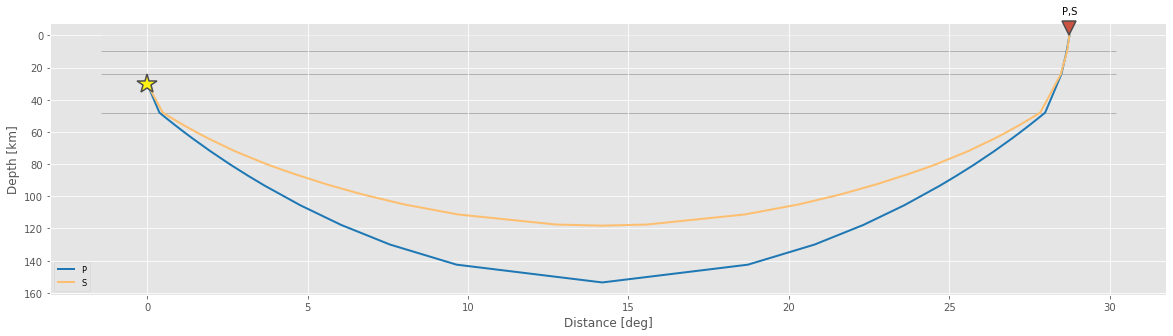

In [16]:
## epicentral distance

# event S0235b
event_lat = 11.59
event_lon = 163.79
event_dep_km = 30.0  # event depth in km

print("event:")
print("  lat/lon = {} / {}".format(event_lat,event_lon))
print("  depth   = ",event_dep_km,"(km)")
print("")

# InSight Lander station ELYSE.XB
ELYSE = { 'name': 'ELYSE', 'lat': 4.502384, 'lon': 135.623444 }   
stations = [ ELYSE ]

# epicentral distance (Haversine formula)
def get_epicentral_distance(event_lat,event_lon,sta_lat,sta_lon):
    from math import pi,sin,cos,asin,sqrt
    # converts to radians
    lat1_radians = event_lat * pi/180.0
    lon1_radians = event_lon * pi/180.0
    lat2_radians = sta_lat * pi/180.0
    lon2_radians = sta_lon * pi/180.0

    mid_lat = (lat1_radians - lat2_radians)/2.0
    mid_lon = (lon1_radians - lon2_radians)/2.0

    tmp = sqrt( pow(sin(mid_lat),2) + cos(lat1_radians)*cos(lat2_radians)*pow(sin(mid_lon),2) )

    distance_radians = 2.0 * asin(tmp)
    dist = distance_radians * 180.0/pi
    
    return dist

# show epicentral distances and main arrival times
for station in stations:    
    sta_lat = station['lat']
    sta_lon = station['lon']
    dist = get_epicentral_distance(event_lat,event_lon,sta_lat,sta_lon)
    
    print("station {}: ".format(station['name']))
    print("  lat/lon = {} / {}".format(sta_lat,sta_lon))
    print("  epicentral distance = ",dist,"(degree)")
    print("")

    # P, S arrival times (can have multiple P, S arrivals)
    arrivals_P = model.get_travel_times(source_depth_in_km=event_dep_km,
                                        distance_in_degree=dist, 
                                        phase_list=["ttall"])  # using 'ttall' in case Pn would be first, instead of P

    arrivals_S = model.get_travel_times(source_depth_in_km=event_dep_km,
                                        distance_in_degree=dist, 
                                        phase_list=["S"])
    
    # traveltimes for first arrivals    
    print("  P: ",arrivals_P[0])
    print("  S: ",arrivals_S[0])
    print("")
    
    # plot rays for first arrivals
    arrivals_P = model.get_ray_paths(source_depth_in_km=event_dep_km, distance_in_degree=dist, phase_list=["ttall"])
    arrivals_S = model.get_ray_paths(source_depth_in_km=event_dep_km, distance_in_degree=dist, phase_list=["S"])
    
    arrivals = obspy.taup.tau.Arrivals([],model=model.model)
    arrivals.append(arrivals_P[0])
    arrivals.append(arrivals_S[0])

    ax = arrivals.plot_rays(plot_type="cartesian",label_arrivals=True,legend=True)
    

In [17]:
## arrival times
print("all arrival times:")
      
# takes InSight Lander station
station = ELYSE
sta_lat = station['lat']
sta_lon = station['lon']

# station epicentral distance in degree
dist = get_epicentral_distance(event_lat,event_lon,sta_lat,sta_lon)

print("  source depth: {} km, distance: {}°".format(event_dep_km,dist))

#phases = ["P","PP","PPP","PPS","p","pPcP","PKIKP","PKJKP","S","SP","SS","SSS","pP","sP","ScS","SKKS"]
phases = ["ttall"]

arrivals = model.get_travel_times(source_depth_in_km=event_dep_km,
                                  distance_in_degree=dist, 
                                  phase_list=phases)

print("  all possible arrivals: ",arrivals) 

all arrival times:
  source depth: 30.0 km, distance: 28.751958530519374°
  all possible arrivals:  23 arrivals
	P phase arrival at 224.466 seconds
	pP phase arrival at 235.477 seconds
	PP phase arrival at 240.795 seconds
	sP phase arrival at 241.333 seconds
	PcP phase arrival at 397.113 seconds
	S phase arrival at 397.550 seconds
	SP phase arrival at 400.343 seconds
	sS phase arrival at 416.915 seconds
	SS phase arrival at 424.071 seconds
	ScP phase arrival at 557.631 seconds
	PcS phase arrival at 562.978 seconds
	ScS phase arrival at 732.003 seconds
	PKiKP phase arrival at 880.489 seconds
	pPKiKP phase arrival at 893.896 seconds
	sPKiKP phase arrival at 899.195 seconds
	SKiKP phase arrival at 1033.279 seconds
	PKIKKIKP phase arrival at 1737.405 seconds
	SKIKKIKP phase arrival at 1891.299 seconds
	PKIKKIKS phase arrival at 1896.603 seconds
	SKIKKIKS phase arrival at 2050.222 seconds
	PKIKPPKIKP phase arrival at 2099.349 seconds
	PKPPKP phase arrival at 2276.528 seconds
	SKIKSSKIKS pha

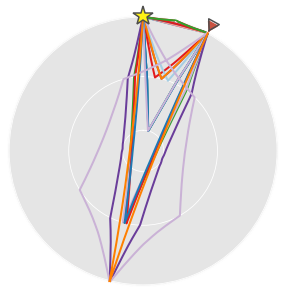

In [18]:
arrivals = model.get_ray_paths(source_depth_in_km=event_dep_km, 
                               distance_in_degree=dist, 
                               phase_list=phases)
ax = arrivals.plot_rays()

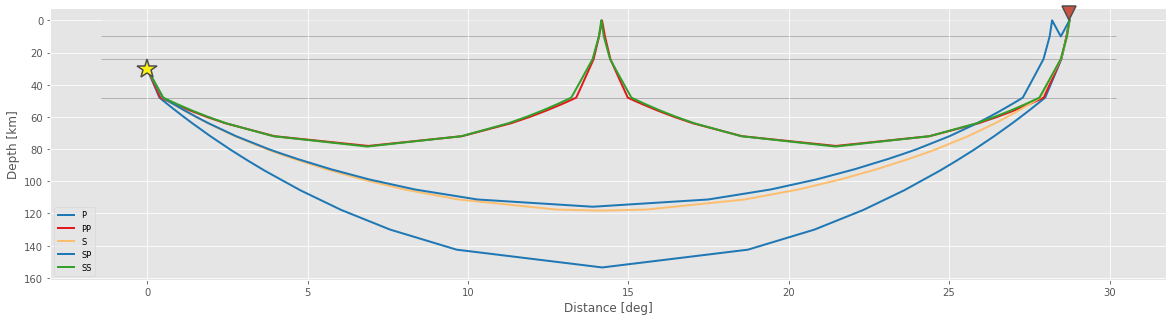

In [19]:
arrivals = model.get_ray_paths(source_depth_in_km=event_dep_km,
                               distance_in_degree=dist,
                               phase_list=["P","Pn","PP","S","Sn","SP","PS","SS"])  # 
ax = arrivals.plot_rays(plot_type="cartesian", legend=True)

done. 